<a href="https://colab.research.google.com/github/AeroEng16/machine-learning-with-python-logistic-regression-3211129/blob/main/04_PyTorchCustomDatasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Tutorial 4: Custom Datasets

We've used some datasets with PyTorch before but how do you get your own data into PyTorch?

One of the ways to do so is via custom datasets.

## Domain Libraries

Depending on what you are working on, vision, text, audio etc. you'll want to look into each of the PyTorch domain libraries for existing dataloading libraries

## 0.Importing PyTorch and setting up Device agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu121'

In [2]:
# Device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1. Get Data

Our dataset is a subset of the Food101 dataset. Food101 starts with 101 different classes of food and 1000 images per class (750 training and 250 test). Our dataset starts with 3 classes fo food and only 10% of the images (~75 training and 25 test)

This is done to try things out on a small scale and then increase scale when necessary. Speeds up development.

In [4]:
import requests
import zipfile
from pathlib import Path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists. ")
else:
  print(f"{image_path} does not exist, creating it")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)


with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  print("Unzipping datafile")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating it
Unzipping datafile


## 2. Data preparation and exploration

In [5]:
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")


In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza


In [7]:
# Setup train and testing paths

train_dir = image_path / "train"
test_dir = image_path/"test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an Image
Lets write some code to:
1. Get all of the iamge paths
2. Pick a random image path using python `random.choice()`
3. Get the image classname using `pathlib.Path.parent.stem`
4. Open the image with PIL
5. Show the image and print metadata

random image path: data/pizza_steak_sushi/train/steak/3518960.jpg
Random Image class: steak
Image height: 512
Image width: 384


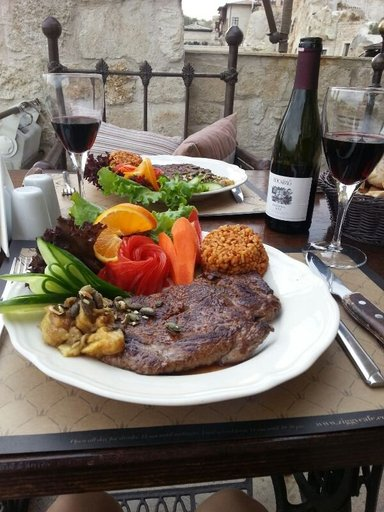

In [29]:
import random
from PIL import Image
import pathlib
# set the seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
#2. Pick random image path
randomImagePath = random.choice(image_path_list)

#3. Get random image class name
randomImageClass = randomImagePath.parent.stem

#4. Show the iamge with PIl
img = Image.open(randomImagePath)

#5. Print metadata
print(f"random image path: {randomImagePath}")
print(f"Random Image class: {randomImageClass}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 383.5, 511.5, -0.5)

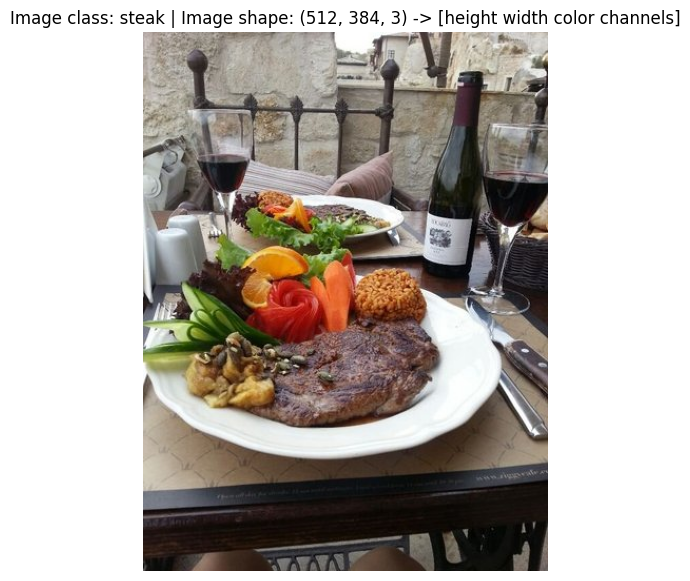

In [30]:
import numpy as np
import matplotlib.pyplot as plt

#Turn the image into array

img_as_array = np.asarray(img)

# Plot image with Matplotlib.plt
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {randomImageClass} | Image shape: {img_as_array.shape} -> [height width color channels]")
plt.axis(False)


##3 Transforming our dataset

Before we can use our image data with PyTorch:
 1. Turn your target data into tensors
 2. Turn it into a torch Dataset and subsequently a dataloader

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with torchvision.transforms

In [41]:
# write a transform for image

data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [34]:
data_transform(img).shape

torch.Size([3, 64, 64])

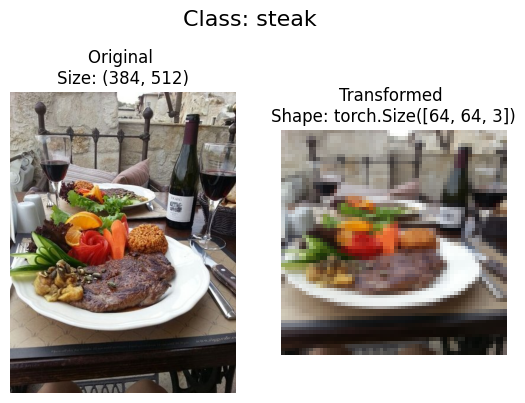

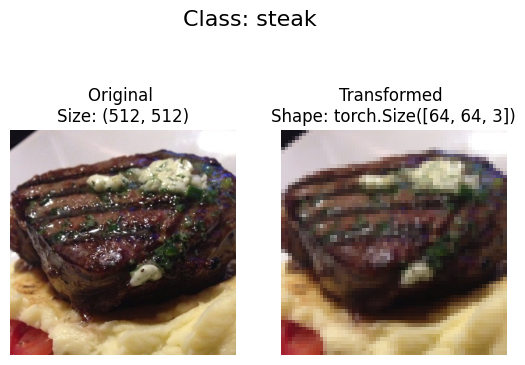

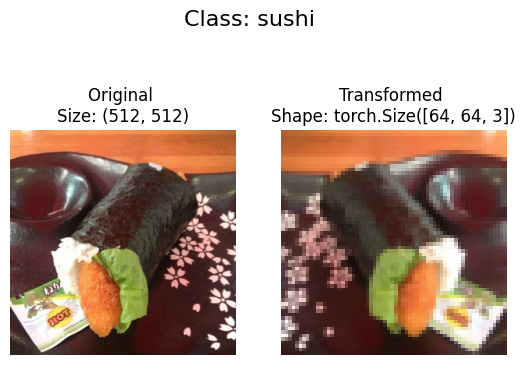

In [42]:
def plot_transformed_images(image_paths: list,transform,n=3,seed=None):
  """
  Selects random images from a path of images and loads/transforms then
  and plots the original vs the transformed version.
  """

  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # note we will need to change shape for Matplotlib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                        transform=data_transform,
                        n = 3,
                        seed=42)

